In [33]:
#import necessary libraries/packages
import pandas as pd
import numpy as np
import PIL
import tensorflow as tf
import pathlib

#get path of csv file. df = dataframe
df = pd.read_csv("/content/drive/MyDrive/kittyfrog.csv")
print(df)

#paths of training and test data
training_data_path = "/content/drive/MyDrive/train"
test_data_path = "/content/drive/MyDrive/test"
valid_data_path = "/content/drive/MyDrive/valid"

color_mode = "grayscale"
number_colour_layers = 1
image_size = (300, 300)
image_shape = image_size + (number_colour_layers,)
SEED = 42

def get_image_data(data_path, color_mode, image_size, seed = None, subset = None, validation_split = None):
    if subset:
        validation_split = 0.2
    return tf.keras.preprocessing.image_dataset_from_directory(
        data_path,
        color_mode=color_mode,
        image_size=image_size,
        seed=seed,
        validation_split=validation_split,
        subset=subset
    )

def get_image_data(data_path, color_mode, image_size, seed = None, subset = None, validation_split = None):
    if subset:
        validation_split = 0.2
    raw_data_set = \
    tf.keras.preprocessing.image_dataset_from_directory(
        data_path,
        color_mode=color_mode,
        image_size=image_size,
        seed=seed,
        validation_split=validation_split,
        subset=subset
    )

    return raw_data_set.cache().prefetch(
        buffer_size = tf.data.experimental.AUTOTUNE
    )

def get_image_data(data_path, color_mode, image_size, seed = None, subset = None, validation_split = None):
    if subset:
        validation_split = 0.2
    raw_data_set = \
    tf.keras.preprocessing.image_dataset_from_directory(
        data_path,
        color_mode=color_mode,
        image_size=image_size,
        seed=seed,
        validation_split=validation_split,
        subset=subset
    )

    raw_data_set.class_names.sort()

    return {
        "data": raw_data_set.cache().prefetch(
        buffer_size = tf.data.experimental.AUTOTUNE
        ),
        "classNames": raw_data_set.class_names
    }

training_ds = get_image_data(
    training_data_path,
    color_mode,
    image_size,
    SEED,
    subset = "training"
)
validation_ds = get_image_data(
    valid_data_path,
    color_mode,
    image_size,
    SEED,
    subset = "validation"
)
test_ds = get_image_data(
    test_data_path,
    color_mode,
    image_size
)


equivalence_check = training_ds["classNames"] == validation_ds["classNames"]
assert_fail_message = "Training and Validation classes should match"
assert(equivalence_check), assert_fail_message
class_names = training_ds["classNames"]
number_classes = len(class_names)


     ID               filepaths labels data_set
0     0  train/kitty/kitty1.jpg  kitty    train
1     0  train/kitty/kitty2.jpg  kitty    train
2     0  train/kitty/kitty3.jpg  kitty    train
3     0  train/kitty/kitty4.jpg  kitty    train
4     0  train/kitty/kitty5.jpg  kitty    train
..   ..                     ...    ...      ...
102   1    valid/frog/frog2.jpg   frog    valid
103   1    valid/frog/frog3.jpg   frog    valid
104   1    valid/frog/frog4.jpg   frog    valid
105   1    valid/frog/frog5.jpg   frog    valid
106   1    valid/frog/frog6.jpg   frog    valid

[107 rows x 4 columns]
Found 57 files belonging to 2 classes.
Using 46 files for training.
Found 15 files belonging to 2 classes.
Using 3 files for validation.
Found 14 files belonging to 2 classes.


In [24]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=image_shape)
]

def conv_2d_pooling_layers(filters, number_colour_layers):
    return [
        tf.keras.layers.Conv2D(
            filters,
            number_colour_layers,
            padding='same',
            activation='relu'
        ),
        tf.keras.layers.MaxPooling2D()
    ]

core_layers = \
    conv_2d_pooling_layers(16, number_colour_layers) + \
    conv_2d_pooling_layers(32, number_colour_layers) + \
    conv_2d_pooling_layers(64, number_colour_layers)


dense_layers = [
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(number_classes)
]

model = tf.keras.Sequential(
    preprocessing_layers +
    core_layers +
    dense_layers
)

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy']
)

In [41]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)
history = model.fit(
    training_ds["data"],
    validation_data = validation_ds["data"],
    epochs = 20,
    callbacks = [callback]
)

Epoch 1/20
2/2 [==============================] - 5s 1s/step - loss: 0.1050 - accuracy: 1.0000 - val_loss: 0.3443 - val_accuracy: 0.6667
Epoch 2/20
2/2 [==============================] - 2s 684ms/step - loss: 0.0850 - accuracy: 1.0000 - val_loss: 0.3978 - val_accuracy: 0.6667
Epoch 3/20
2/2 [==============================] - 2s 717ms/step - loss: 0.0701 - accuracy: 1.0000 - val_loss: 0.4038 - val_accuracy: 0.6667
Epoch 4/20
2/2 [==============================] - 2s 745ms/step - loss: 0.0553 - accuracy: 1.0000 - val_loss: 0.3746 - val_accuracy: 0.6667


In [39]:
model.evaluate(test_ds["data"])

1/1 [==============================] - 0s 153ms/step - loss: 0.2221 - accuracy: 0.8571


[0.22210638225078583, 0.8571428656578064]

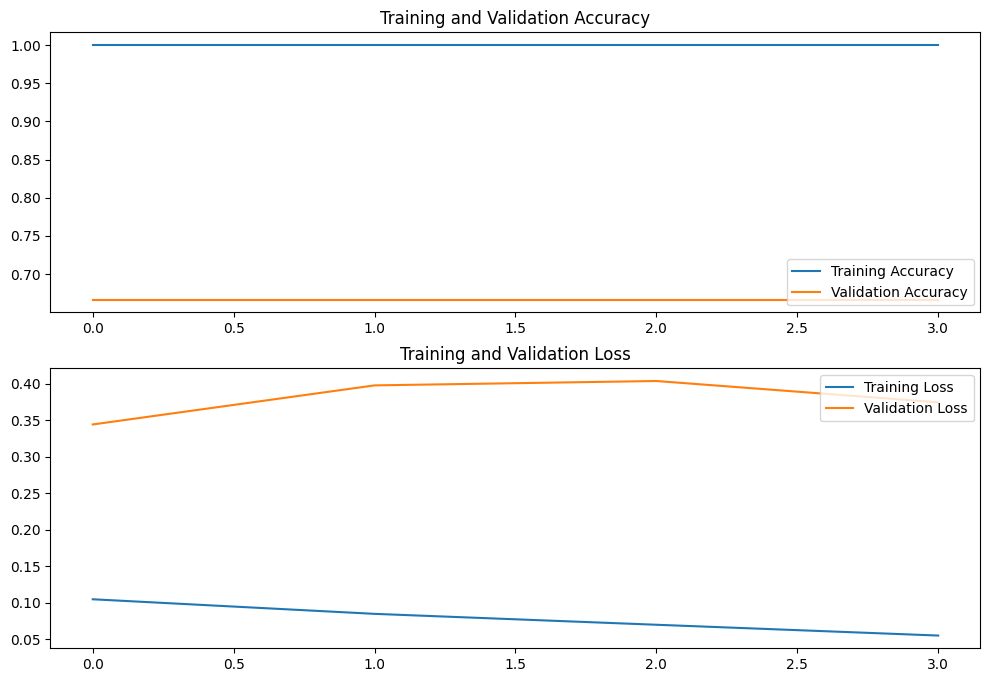

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
